
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [ ]:
import pandas as pd
from sklearn.pipeline import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import *
from sklearn.linear_model import LogisticRegression

In [ ]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")

In [ ]:
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [ ]:
X_cp = ha[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]
y_cp = ha["cp"]

from sklearn.model_selection import *
X_cp_train, X_cp_test, y_cp_train, y_cp_test = train_test_split(
    X_cp, y_cp, test_size=0.3, random_state=1, stratify=y_cp
)

In [ ]:
from sklearn.preprocessing import *
from sklearn.metrics import *

knn_cp = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors=5)
)

knn_cp.fit(X_cp_train, y_cp_train)
y_cp_pred_knn = knn_cp.predict(X_cp_test)

print(confusion_matrix(y_cp_test, y_cp_pred_knn))
print(classification_report(y_cp_test, y_cp_pred_knn))

[[29  2  8  0]
 [ 2  1 10  0]
 [12  4  8  0]
 [ 1  2  3  0]]
              precision    recall  f1-score   support

           0       0.66      0.74      0.70        39
           1       0.11      0.08      0.09        13
           2       0.28      0.33      0.30        24
           3       0.00      0.00      0.00         6

    accuracy                           0.46        82
   macro avg       0.26      0.29      0.27        82
weighted avg       0.41      0.46      0.44        82



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
tree_cp = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_cp.fit(X_cp_train, y_cp_train)

tree_pred = tree_cp.predict(X_cp_test)

print(confusion_matrix(y_cp_test, tree_pred))

print(classification_report(y_cp_test, tree_pred))

tree_cp.feature_importances_

[[25  3 10  1]
 [ 2  4  7  0]
 [ 5  7 11  1]
 [ 1  1  4  0]]
              precision    recall  f1-score   support

           0       0.76      0.64      0.69        39
           1       0.27      0.31      0.29        13
           2       0.34      0.46      0.39        24
           3       0.00      0.00      0.00         6

    accuracy                           0.49        82
   macro avg       0.34      0.35      0.34        82
weighted avg       0.50      0.49      0.49        82



array([0.04238612, 0.04448688, 0.13966611, 0.09734249, 0.        ,
       0.23093443, 0.44518398])

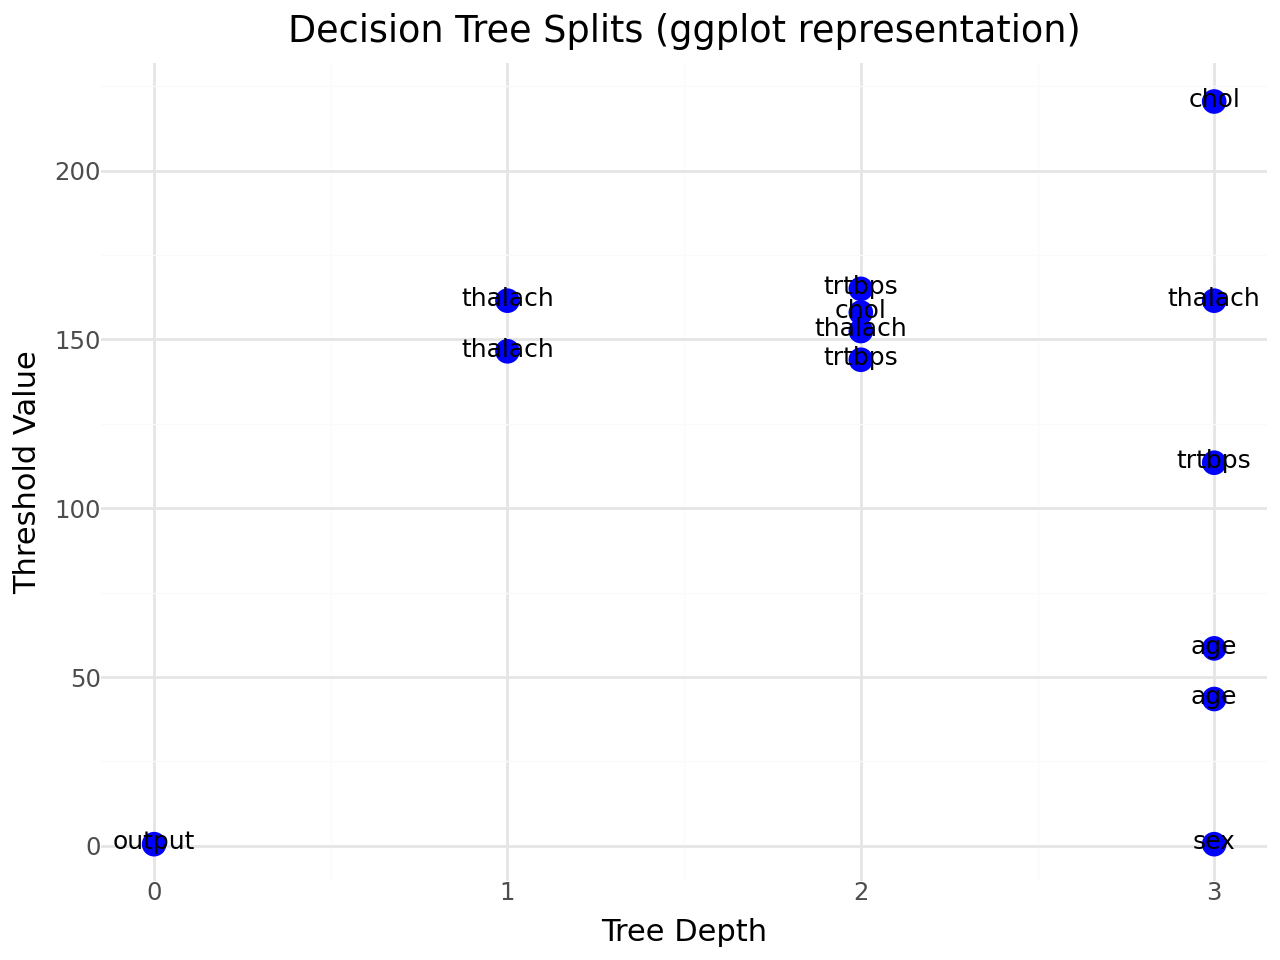

In [ ]:
from plotnine import *

nodes = []

def extract(node, depth=0):
    if tree_cp.tree_.feature[node] != -2:
        feat = X_cp.columns[tree_cp.tree_.feature[node]]
        thresh = tree_cp.tree_.threshold[node]
        nodes.append([depth, feat, thresh])
        extract(tree_cp.tree_.children_left[node], depth+1)
        extract(tree_cp.tree_.children_right[node], depth+1)

extract(0)

tree_df = pd.DataFrame(nodes, columns=["depth","feature","threshold"])

(
    ggplot(tree_df, aes(x="depth", y="threshold", label="feature")) +
    geom_point(size=4, color="blue") +
    geom_text(nudge_y=0.5, size=9) +
    labs(
        title="Decision Tree Splits (ggplot representation)",
        x="Tree Depth",
        y="Threshold Value"
    ) +
    theme_minimal()
)

The decision tree initially divides individuals according to their overall heart-disease risk, followed by their exercise heart rate (thalach), and then factors like blood pressure and cholesterol. This pattern suggests that chest-pain category is highly associated with both disease severity and general cardiovascular health

In [ ]:
from sklearn.discriminant_analysis import *

lda_cp = make_pipeline(
    StandardScaler(),
    LinearDiscriminantAnalysis()
)

lda_cp.fit(X_cp_train, y_cp_train)
lda_pred = lda_cp.predict(X_cp_test)

print(confusion_matrix(y_cp_test, lda_pred))

print(classification_report(y_cp_test, lda_pred))

lda_cp.named_steps["lineardiscriminantanalysis"].coef_
lda_cp.named_steps["lineardiscriminantanalysis"].intercept_

[[25  1 13  0]
 [ 1  0 12  0]
 [ 5  1 18  0]
 [ 1  0  5  0]]
              precision    recall  f1-score   support

           0       0.78      0.64      0.70        39
           1       0.00      0.00      0.00        13
           2       0.38      0.75      0.50        24
           3       0.00      0.00      0.00         6

    accuracy                           0.52        82
   macro avg       0.29      0.35      0.30        82
weighted avg       0.48      0.52      0.48        82



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


array([-1.07111631, -2.28144393, -1.4315481 , -2.9495684 ])

## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

In [ ]:
ha["cp_is_3"] = (ha["cp"] == 3).astype(int)
X = ha[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]

from sklearn.metrics import *

def cp_f1(cp_value):
    y = (ha["cp"] == cp_value).astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    model = LogisticRegression(max_iter=5000)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred)

In [ ]:
f1_0 = cp_f1(0)
f1_1 = cp_f1(1)
f1_2 = cp_f1(2)
f1_3 = cp_f1(3)

f1_0, f1_1, f1_2, f1_3

(0.75, 0.0, 0.13333333333333333, 0.0)

The OvR logistic regression model performed strongest on classifying chest-pain type 0, achieving an F1 score of 0.75. In other words, the model is considerably more effective at detecting patients in category 0 than those in categories 1, 2, or 3.

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

In [ ]:
ha_01 = ha[ha["cp"].isin([0, 1])].copy()

ha_01["y"] = (ha_01["cp"] == 1).astype(int)

X_01 = ha_01[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]
y_01 = ha_01["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X_01, y_01, test_size=0.3, random_state=42, stratify=y_01
)

logreg_01 = LogisticRegression(max_iter=5000)
logreg_01.fit(X_train, y_train)

y_prob = logreg_01.predict_proba(X_test)[:, 1]

auc_01 = roc_auc_score(y_test, y_prob)
auc_01

np.float64(0.7297830374753452)

In [ ]:
ha_02 = ha[ha["cp"].isin([0, 2])].copy()

ha_02["y"] = (ha_02["cp"] == 2).astype(int)

X_02 = ha_02[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]
y_02 = ha_02["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X_02, y_02, test_size=0.3, random_state=42, stratify=y_02
)

logreg_02 = LogisticRegression(max_iter=5000)
logreg_02.fit(X_train, y_train)

y_prob = logreg_02.predict_proba(X_test)[:, 1]

auc_02 = roc_auc_score(y_test, y_prob)
auc_02

np.float64(0.8803418803418803)

In [ ]:
ha_03 = ha[ha["cp"].isin([0, 3])].copy()

ha_03["y"] = (ha_03["cp"] == 3).astype(int)

X_03 = ha_03[["age", "sex", "trtbps", "chol", "restecg", "thalach", "output"]]
y_03 = ha_03["y"]

X_train, X_test, y_train, y_test = train_test_split(
    X_03, y_03, test_size=0.3, random_state=42, stratify=y_03
)

logreg_03 = LogisticRegression(max_iter=5000)
logreg_03.fit(X_train, y_train)

y_prob = logreg_03.predict_proba(X_test)[:, 1]

auc_03 = roc_auc_score(y_test, y_prob)
auc_03

np.float64(0.7264957264957266)

The OvO method was most effective when separating classes 0 and 2, reaching a ROC-AUC of 0.8803 for that pair.